**Homework 3 Foundations of Machine Learning**

Miles Pophal

In [2]:
import pandas as pd 
import sklearn 
import numpy as np 
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator,ClassifierMixin 
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


In [45]:
''' 
Data importing and preprocessing, statistics calculated with training data
since data is numerical, no one-hot encoding needed. 

Later in assignment we split the training data, to keep feature/label pair I split the data first,
otherwise using train_test_split is preferred. 
'''
data = pd.read_csv('./data/spambase.data.shuffled').to_numpy()


train_data = data[0:3450]               
test_data = data[3450:]

train_features = train_data[:,0:-1]
test_features = test_data[:,0:-1]

train_labels = train_data[:,-1]
test_labels = test_data[:,-1]

mean_estimate = np.mean(train_features,axis=0)
stdev_estimate = np.std(train_features,axis=0)

train_normal_features = (train_features - mean_estimate)/stdev_estimate 
test_normal_features = (test_features - mean_estimate)/stdev_estimate


In [12]:
class Adaboost(ClassifierMixin,BaseEstimator):
    '''Adaboost Adaboost Classifier for stumps built with sk-learn standards. 

    Initialized with boost_parameter which describes the number of boosting rounds. 
    fit function follows page 4 https://cs.nyu.edu/~mohri/mls/ml_boosting.pdf 

    This isn't efficient because at each fit it creates a list of stump classifiers. 
    Lambda functions made it more efficient but less readable. 
    '''
    def __init__(self,boost_parameter=10):
        self.boost_parameter = boost_parameter

    def fit(self, X,y):
        '''fit Fits the classifier to the training data 

        Follows the algorithm described in the link above by creating a list of length boost_parameter
            -each item is a decision tree of depth 1 (stump) fit to the input sample and labels
            -errors and weights are calculated as in algorithm


        :param X: Training data of shape (n_samples, k_features)
        :type X: numpy array 
        :param y: training labels of shape (n_samples,) for binary classification 
        :type y: numpy array 
        :return: fitted classifier 
        '''
        T = self.boost_parameter 
        X, y = check_X_y(X, y)          #meets sk-learn standards
        
        sample_size = X.shape[0]
        weights = np.ones(sample_size)/sample_size 
        self.base_list_ = []*T    
        self.alpha_ = np.zeros(T)

        for i in range(T):
            t = tree.DecisionTreeClassifier(max_depth=1)
            t.fit(X,y,sample_weight=weights)

            #if t.score(sample,labels)<.5:
            #    h.append(t.fit(sample,-1*labels,sample_weight=weights)) 
            #else: 
            #    h.append(t.fit(sample,labels,sample_weight=weights)) 

            self.base_list_.append(t.fit(X,y,sample_weight=weights))        #adds fitted stump to list 
            epsilon = self.base_list_[i].score(X,y)
            self.alpha_[i] = .5*np.log((1-epsilon)/epsilon)

            Z = 2*np.sqrt(epsilon*(1-epsilon)) 
            for j in range(sample_size):
                x = X[j] 
                x=x.reshape(1,-1)
                h_x = self.base_list_[i].predict(x).item()
                weights[j] = (weights[j]*np.exp(-self.alpha_[i]*y[j]*h_x))/Z 
    
        return self 
    
    def predict(self,X):
        '''predict predicted labels of input features X 

        Predicts the classes for binary classification based page 4 of the linked notes. Checks if classifier has been fitted and if data is in standard form then loops over the list of stumps and sums the stump predicton multiplied by stump weight. Finally takes the sign to map into {-1,+1}.

        :param X: input data of shape (n_samples, k_features)
        :type X: numpy array
        :return: list in {-1,+1}^n_samples
        :rtype: numpy array 
        '''
        check_is_fitted(self)
        X = check_array(X)

        y = 0

        for idx, classif in enumerate(self.base_list_):
            y += self.alpha_[idx]*classif.predict(X) 

        return np.sign(y) 

To get random disjoint splits, we shuffle the training data and partition along equal size. Making k larger than 2 yields no benefits and only drags the code (likely from my inefficient implementation). 

In [24]:
cutoff_data = train_data
split_size = 345 #3450/10 
np.random.shuffle(cutoff_data)          #randomly split the input data 

splits = []
for i in range(10):
    splits.append(cutoff_data[split_size*i:split_size*(i+1)])

split_features = []
split_labels = []
cross_val_scores = []

for i in range(10):
    split_features.append((splits[i])[:,0:-1])
    split_labels.append(splits[i][:,-1])

k = 2
#calculate the cross-val score and stdev for each set of boosting rounds
cv_scores = np.zeros(10**k-1)
std_scores = np.zeros(10**k-1)
for p in range(1,10**k):
    ada_classifier = Adaboost(boost_parameter=p)
    for i in range(10):
        ada_classifier.fit(split_features[i],split_labels[i]) 
        cross_val_scores.append(cross_val_score(ada_classifier,split_features[i],split_labels[i])) 
    cv_scores[p-1] = 1 - np.average(cross_val_scores)
    std_scores[p-1] = np.std(cross_val_scores)


**Plotting**

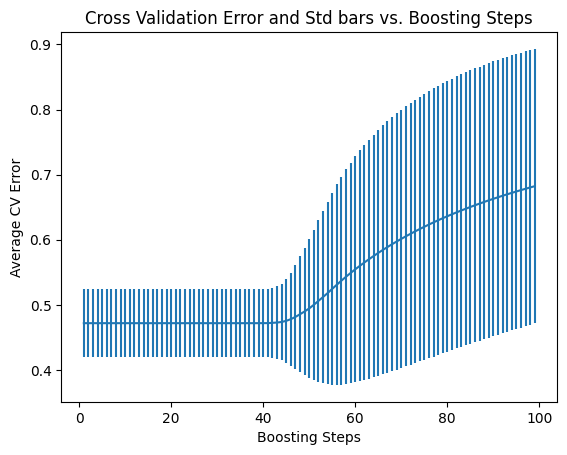

In [25]:
x = np.arange(1,10**k,step=1) 
plt.title('Cross Validation Error and Std bars vs. Boosting Steps')
plt.xlabel('Boosting Steps')
plt.ylabel('Average CV Error')
plt.errorbar(x,cv_scores,std_scores) 
plt.show()

Optimal Value seems to be 40. Now we re-run the boosting loops except we fit over the entire training data instead of the separate smaller batches. 

In [41]:
T_star = np.argmin(cv_scores)      
test_error = np.zeros(T_star-1)
train_error = np.zeros(T_star-1)

for i in range(1,T_star):
    ada_classifier = AdaBoostClassifier(n_estimators = i) 
    ada_classifier.fit(train_normal_features,train_labels)
    train_error[i-1] = 1-ada_classifier.score(train_normal_features,train_labels)
    test_error[i-1] =  1-ada_classifier.score(test_normal_features,test_labels)

x = np.arange(1,T_star,step=1)
print('Best Boosting Parameter is ',T_star)

Best Boosting Parameter is  11


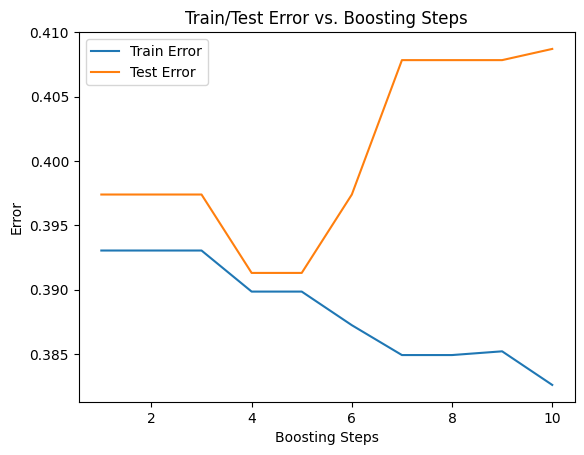

In [42]:
fix, ax = plt.subplots()
ax.set_title('Train/Test Error vs. Boosting Steps') 
ax.set_xlabel('Boosting Steps')
ax.set_ylabel('Error') 
ax.plot(x,train_error,label='Train Error')
ax.plot(x,test_error,label='Test Error')
ax.legend()
plt.show()

Now we compare with the sklearn Adaboost.

In [28]:
cv_scores_sk = np.zeros(10**k-1)
std_scores_sk = np.zeros(10**k-1)

cross_val_scores = []

for p in range(1,10**k):
    ada_sk = AdaBoostClassifier(n_estimators = p) 
    for i in range(10):
        ada_sk.fit(split_features[i],split_labels[i]) 
        cross_val_scores.append(cross_val_score(ada_sk,split_features[i],split_labels[i])) 
    cv_scores_sk[p-1] = 1 - np.average(cross_val_scores)
    std_scores_sk[p-1] = np.std(cross_val_scores)


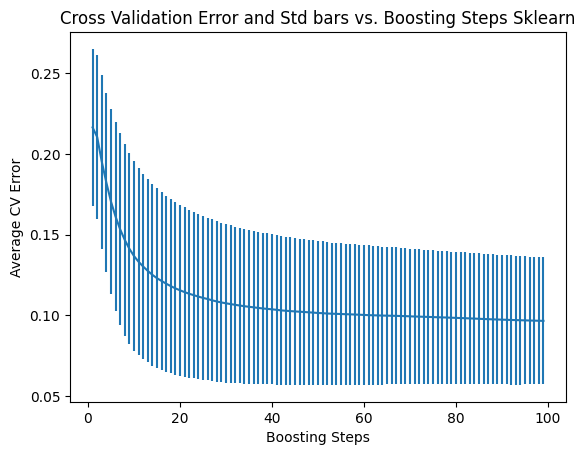

In [37]:
x = np.arange(1,10**k,step=1) 
plt.title('Cross Validation Error and Std bars vs. Boosting Steps Sklearn')
plt.xlabel('Boosting Steps')
plt.ylabel('Average CV Error')
plt.errorbar(x,cv_scores_sk,std_scores_sk) 
plt.show()

In [38]:
T_star = np.argmin(cv_scores_sk)      
test_error_sk = np.zeros(T_star-1)
train_error_sk = np.zeros(T_star-1)

for i in range(1,T_star):
    ada_classifier = AdaBoostClassifier(n_estimators = i) 
    ada_classifier.fit(train_normal_features,train_labels)
    train_error_sk[i-1] = 1-ada_classifier.score(train_normal_features,train_labels)
    test_error_sk[i-1] =  1-ada_classifier.score(test_normal_features,test_labels)

x2 = np.arange(1,T_star,step=1)
print('Best Boosting Parameter for Sklearn AdaBoost is ',T_star)

Best Boosting Parameter for Sklearn AdaBoost is  98


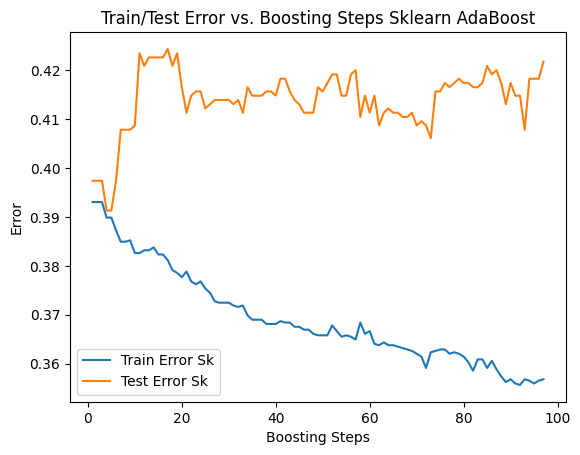

In [39]:
fix, ax = plt.subplots()
ax.set_title('Train/Test Error vs. Boosting Steps Sklearn AdaBoost') 
ax.set_xlabel('Boosting Steps')
ax.set_ylabel('Error') 
ax.plot(x2,train_error_sk,label='Train Error Sk')
ax.plot(x2,test_error_sk,label='Test Error Sk')
ax.legend()
plt.show()

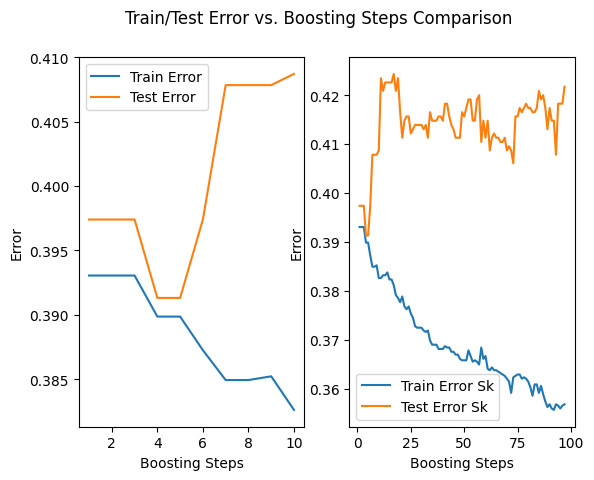

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Train/Test Error vs. Boosting Steps Comparison') 
ax1.set_xlabel('Boosting Steps')
ax2.set_xlabel('Boosting Steps')
ax1.set_ylabel('Error') 
ax2.set_ylabel('Error') 
ax1.plot(x,train_error,label='Train Error')
ax1.plot(x,test_error,label='Test Error ')
ax2.plot(x2,train_error_sk,label='Train Error Sk')
ax2.plot(x2,test_error_sk,label='Test Error Sk')
ax1.legend()
ax2.legend()
plt.show()

The trajectories and bounds are similar, but the increase in cross-validation error for the scratch implementation cutoff the learning. One avenue to explore is potential weight overflow issues since problematic points could be subject to exploding weights. 